In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix,classification_report
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()
%matplotlib inline

In [2]:
df= pd.read_csv("New_training.csv")
df.head()

,Ictype,SAMPLE_1,SAMPLE_2,SAMPLE_3
0,Banana,147,182,135
1,Banana,60,105,60
2,Banana,43,77,35
3,Banana,141,170,122
4,Banana,43,81,30


In [3]:
df.shape

(3150, 4)

In [4]:
X= df.drop("Ictype",axis=1)
y= df["Ictype"]

In [5]:
le= LabelEncoder()

In [6]:
X_train,X_test,y_train,y_test= train_test_split(X,y,test_size=0.2,random_state=42)

In [7]:
y_train= le.fit_transform(y_train)
y_test= le.transform(y_test)

In [8]:
le.classes_

array(['Banana', 'Fresh_Field', 'Harvested'], dtype=object)

In [9]:
rfc= RandomForestClassifier(max_depth=7)

In [10]:
rfc.fit(X_train,y_train)

RandomForestClassifier(max_depth=7)

In [11]:
rfc.score(X_train,y_train)

0.8892857142857142

In [12]:
rfc.score(X_test,y_test)

0.8809523809523809

In [13]:
preds= rfc.predict(X_test)

In [14]:
conf= confusion_matrix(y_test,preds)

In [15]:
conf

array([[225,   0,   3],
       [  1, 177,  23],
       [  0,  48, 153]], dtype=int64)

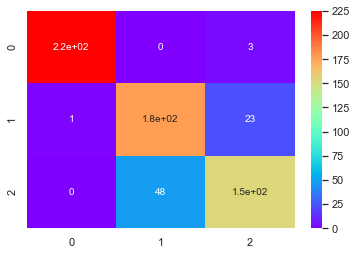

In [16]:
sns.heatmap(conf,cmap="rainbow",annot=True);

In [17]:
classification= classification_report(y_test,preds)
print(classification)

              precision    recall  f1-score   support

           0       1.00      0.99      0.99       228
           1       0.79      0.88      0.83       201
           2       0.85      0.76      0.81       201

    accuracy                           0.88       630
   macro avg       0.88      0.88      0.88       630
weighted avg       0.88      0.88      0.88       630



In [18]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier

In [19]:
models= {'Decision_tree': DecisionTreeClassifier(),
         'K-Neighbors': KNeighborsClassifier(n_neighbors=5),
         'Random_forest': RandomForestClassifier(n_estimators=100,max_depth=7),
         'Adaboost': AdaBoostClassifier()}

train_score={}
test_score={}

for name,model in models.items():
    model.fit(X_train,y_train)
    train_score[name]= model.score(X_train,y_train)
    test_score[name]= model.score(X_test,y_test)

In [20]:
train_score

{'Decision_tree': 0.9904761904761905,
 'K-Neighbors': 0.9035714285714286,
 'Random_forest': 0.8928571428571429,
 'Adaboost': 0.7194444444444444}

In [21]:
test_score

{'Decision_tree': 0.8158730158730159,
 'K-Neighbors': 0.9063492063492063,
 'Random_forest': 0.8841269841269841,
 'Adaboost': 0.7158730158730159}

In [22]:
from osgeo import gdal

In [23]:
image= 'Test_input.tif'
outRaster = 'output.tif'

In [24]:
ds = gdal.Open(image, gdal.GA_ReadOnly)
rows = ds.RasterYSize
cols = ds.RasterXSize
bands = ds.RasterCount
geo_transform = ds.GetGeoTransform()
projection = ds.GetProjectionRef()
print(rows,cols)
print(bands)

9946 4282
3


In [25]:
array = ds.ReadAsArray()

In [26]:
array = np.stack(array,axis=2)
array = np.reshape(array, [rows*cols,bands])
test = pd.DataFrame(array, dtype='int16')

In [27]:
real_prediction= rfc.predict(test)

In [28]:
classification = real_prediction.reshape((rows,cols))

In [29]:
def createGeotiff(outRaster, data, geo_transform, projection):
   
    driver = gdal.GetDriverByName('GTiff')
    rows, cols = data.shape
    rasterDS = driver.Create(outRaster, cols, rows, 1, gdal.GDT_Int32)
    rasterDS.SetGeoTransform(geo_transform)
    rasterDS.SetProjection(projection)
    band = rasterDS.GetRasterBand(1)
    band.WriteArray(data)
    rasterDS = None


In [30]:
createGeotiff(outRaster,classification,geo_transform,projection)